# VarQFS

This notebook is intended to reproduce the paper by Zhoufal et al. 2023 on Variational quantum algorithm for unconstrained black box binary optimization: Application to feature selection. The goal is to implement another Quantum Feature Selection algorithm.

## Parameters

In [1]:
_label_ = 'kredit'

## Packages

In [2]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_machine_learning.algorithms import VQC
from qiskit.circuit.library import RealAmplitudes

## Data

In [3]:
df = pd.read_table('SouthGermanCredit/SouthGermanCredit.csv.asc', sep=' ')

In [4]:
df

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,24,2,3,1987,1,3,2,3,1,...,1,21,3,1,1,2,1,1,2,0
996,1,24,2,0,2303,1,5,4,3,2,...,1,45,3,2,1,3,2,1,2,0
997,4,21,4,0,12680,5,5,4,3,1,...,4,30,3,3,1,4,2,2,2,0
998,2,12,2,3,6468,5,1,2,3,1,...,4,52,3,2,1,4,2,2,2,0


In [5]:
_cols_ = df.loc[:, df.columns != _label_].columns

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[_cols_], df[_label_], test_size=0.2, random_state=42, stratify=df[_label_])

## Ansatz

In [7]:
def ansatz(num_qubits):
    # create the parameter
    theta = ParameterVector('theta', num_qubits*2)
    qc = QuantumCircuit(num_qubits)

    # parameterize the rotation
    for i in range(num_qubits):
        qc.ry(theta[i], i)
    for i in range(num_qubits-1):
        qc.cnot(i, i+1)

    for i in range(num_qubits):
        qc.ry(theta[i+num_qubits], i)
   
    return qc

In [8]:
feature_map = ansatz(20)

In [ ]:
#RealAmplitudes(num_qubits=None, entanglement='full', reps=3, skip_unentangled_qubits=False, skip_final_rotation_layer=False, parameter_prefix='θ', insert_barriers=False, initial_state=None)

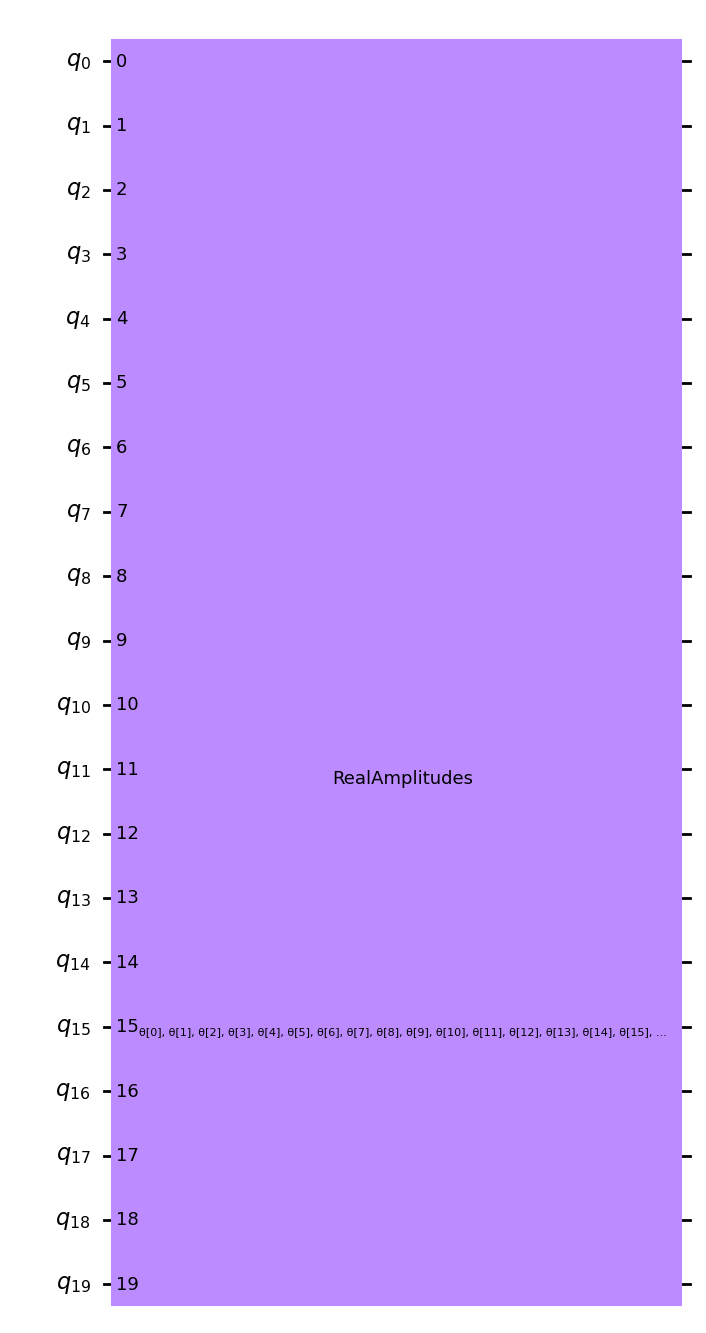

In [21]:
ansatz = RealAmplitudes(20, reps=1, entanglement='linear')  # create the circuit on 3 qubits
qc = QuantumCircuit(20)
qc.compose(ansatz, inplace=True)
qc.draw('mpl')

## Optimizer

In [14]:
from qiskit.algorithms.optimizers import QNSPSA, SPSA, COBYLA

In [10]:
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler as Sampler_prim

In [36]:
backend = Aer.get_backend("aer_simulator_matrix_product_state")
#backend.set_options(device='GPU')
backend.set_options(precision='single')

## Sandbox

In [ ]:
###### from qiskit.algorithms.optimizers import COBYLA, SPSA, QNSPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, RealAmplitudes
from qiskit.utils import algorithm_globals
from qiskit.primitives import Estimator, Sampler
from qiskit.algorithms import MinimumEigensolver, NumPyMinimumEigensolver, VQE
from qiskit.algorithms.minimum_eigensolvers import QAOA, SamplingVQE
from qiskit.algorithms.optimizers import L_BFGS_B, SLSQP, SPSA
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.datasets import ad_hoc_data
import time 
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.problems import QuadraticProgram

### QUBO

### VQE

In [ ]:
def RunVQE(estimator, model, optimizer, operator, init=None):
    
    # Store intermediate results
    history = {"eval_count": [], "parameters": [], "mean": [], "metadata": []}
    
    # Define callback function
    def store_intermediate_result(eval_count, parameters, mean, metadata):
        history["eval_count"].append(eval_count)
        history["parameters"].append(parameters)
        history["mean"].append(mean.real)
            
    #### Enter your code below ####
    
   # Define VQE run
    vqe = VQE(estimator=estimator,
                  ansatz = model, 
                  optimizer=optimizer, 
                  initial_point = init, 
                  callback = store_intermediate_result)

    # Compute minimum_eigenvalue
    result = vqe.compute_minimum_eigenvalue(operator)
    #### Enter your code above ####

    return result, history["mean"]

In [54]:


start_time = time.time()
seed = 1376
algorithm_globals.random_seed = seed

# Use ad hoc data set for training and test data
# X_train, X_test, y_train, y_test
feature_dim = X_train.shape[1]  # dimension of each data point
#training_size = 20
#test_size = 10

feature_map = RealAmplitudes(10, reps=1, entanglement='linear', parameter_prefix='alpha')#.measure_all()
#ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")
#feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")
ansatz = TwoLocal(feature_map.num_qubits, ["ry"], reps=2)

####################################

#qc = QuantumCircuit(feature_dim)  # create a circuit and append the RY variational form
#qc.compose(feature_map, inplace=True)
#qc.draw('mpl')

###################################


print(f'\nThe number of qubits in the ansatz is: {feature_map.num_qubits}\n')
# fidelity for estimation of the geometric tensor
#sampler = Sampler()
#fidelity = QNSPSA.get_fidelity(ansatz, sampler)
#fidelity = ComputeUncompute(sampler=Sampler_prim())
fidelity = QNSPSA.get_fidelity(ansatz,Sampler_prim())



'''vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    quantum_instance=backend,
    #sampler=ComputeUncompute(sampler=Sampler_prim()),
    optimizer= QNSPSA(fidelity, maxiter=100), # works better with SPSA 
)
#vqc.fit(training_features, training_labels)
vqc.fit(np.array(X_train)[:250], np.array(y_train)[:250])''' 

vqe = VQE(
    ansatz= feature_map,
    estimator=Estimator(),
    optimizer=QNSPSA(fidelity, maxiter=100), 
    
)

vqe 
#score = vqc.score(test_features, test_labels)
#score = vqc.score(np.array(X_test)[:100], np.array(y_test)[:100])
end_time = time.time() - start_time 
print(f"Testing accuracy: {score:0.2f}")
print(f"Computation time: {end_time:0.2f} seconds")


The number of qubits in the ansatz is: 10



QiskitMachineLearningError: 'The model has not been fitted yet'

In [13]:
QNSPSA??

Init signature:
QNSPSA(
    fidelity: 'FIDELITY',
    maxiter: 'int' = 100,
    blocking: 'bool' = True,
    allowed_increase: 'float | None' = None,
    learning_rate: 'float | Callable[[], Iterator] | None' = None,
    perturbation: 'float | Callable[[], Iterator] | None' = None,
    resamplings: 'int | dict[int, int]' = 1,
    perturbation_dims: 'int | None' = None,
    regularization: 'float | None' = None,
    hessian_delay: 'int' = 0,
    lse_solver: 'Callable[[np.ndarray, np.ndarray], np.ndarray] | None' = None,
    initial_hessian: 'np.ndarray | None' = None,
    callback: 'CALLBACK | None' = None,
    termination_checker: 'TERMINATIONCHECKER | None' = None,
) -> 'None'
Source:        
class QNSPSA(SPSA):
    r"""The Quantum Natural SPSA (QN-SPSA) optimizer.

    The QN-SPSA optimizer [1] is a stochastic optimizer that belongs to the family of gradient
    descent methods. This optimizer is based on SPSA but attempts to improve the convergence by
    sampling the **natural grad